# Create TensorFlow Record

In [1]:
#!pip  install tensorflow

In [11]:
import tensorflow as tf
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

### Helper Function

In [22]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

In [3]:
# Function to convert image file to TensorFlow Example
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# Function to create a TFRecord file
def create_tfrecord(images_folder, output_file):
    writer = tf.io.TFRecordWriter(output_file)

    # List all subdirectories (assuming each subdirectory is a class)
    classes = os.listdir(images_folder)

    for class_name in classes:
        class_path = os.path.join(images_folder, class_name)
        if not os.path.isdir(class_path):
            continue

        # Get list of image files in the class folder
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for image_file in tqdm(image_files, desc=f"Processing {class_name}"):
            image_path = os.path.join(class_path, image_file)

            # Read the original image without resizing
            image = Image.open(image_path)
            image = np.array(image)
            label = classes.index(class_name)

            # Create a TensorFlow Example
            feature = {
                'image': _bytes_feature(image),
                'label': _int64_feature(label),
            }
            example_proto = tf.train.Example(features=tf.train.Features(feature=feature))

            # Write the Example to the TFRecord file
            writer.write(example_proto.SerializeToString())

    writer.close()

# --- TRAIN TFRecord
# Specify your input folder containing class subfolders (e.g., "class_1", "class_2")
train_folder = r"C:\Users\User\Desktop\GithubProjects\practical-ml-vision\Creating_datasets\train"
# Specify the output TFRecord file
train_tfrecord = r"C:\Users\User\Desktop\GithubProjects\practical-ml-vision\Creating_datasets\train.tfrecord"

# Create TFRecord file
create_tfrecord(train_folder, train_tfrecord)

# --- TRAIN TFRecord
# Specify your input folder containing class subfolders (e.g., "class_1", "class_2")
val_folder = r"C:\Users\User\Desktop\GithubProjects\practical-ml-vision\Creating_datasets\val"
# Specify the output TFRecord file
val_tfrecord = r"C:\Users\User\Desktop\GithubProjects\practical-ml-vision\Creating_datasets\val.tfrecord"

# Create TFRecord file
create_tfrecord(val_folder, val_tfrecord)

Processing pug: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20.68it/s]


### Parse TensorFlow Record

In [4]:
# Function to parse TFRecord
def parse_tfrecord(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    rec = tf.io.parse_single_example(proto, feature_description)

    # Decode the image from bytes
    img = tf.io.decode_jpeg(rec['image'], channels=3)
    label = rec['label']

    return img, label

# Create a TFRecordDataset from the output file
tfrecord_dataset = tf.data.TFRecordDataset([train_tfrecord])

# Map the parse function to the dataset
parsed_dataset = tfrecord_dataset.map(parse_tfrecord)

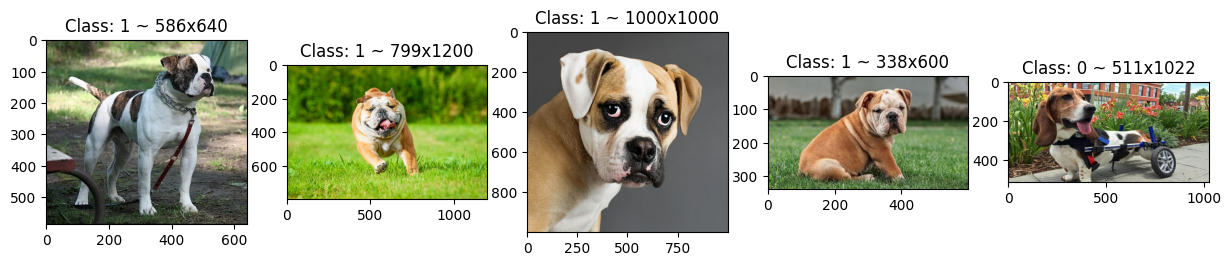

In [5]:
# Shuffle the dataset 
buffer_size = 10000
shuffled_dataset = parsed_dataset.shuffle(buffer_size)

# Iterate through the parsed dataset
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(shuffled_dataset.take(5)):
    #print(img.shape)
    mean_of_image = tf.reduce_mean(img)
    # print(mean_of_image)
    # print(label_int)
    ax[idx].imshow((img.numpy()));
    ax[idx].set_title('Class: {} ~ {}x{}'.format(label_int.numpy(), img.shape[0], img.shape[1]))

### Resize images

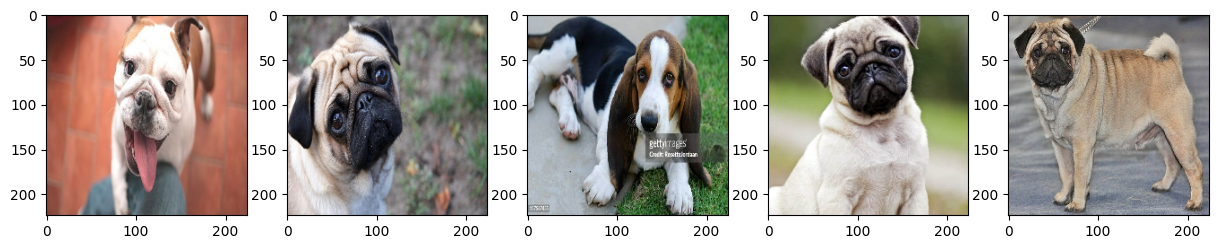

In [6]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
preproc_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(
        height=IMG_HEIGHT, width=IMG_WIDTH,
        input_shape=(None, None, 3))
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0) #Note: This expanding is because we have images of different sizes
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)

    # Cast to integer
    x = tf.cast(x, tf.uint8)
    
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(shuffled_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()))
    #ax[idx].set_title('Class: {} ~ {}x{}'.format(label_int.numpy(), img.shape[0], img.shape[1]))

## Resize keeping aspect ratio

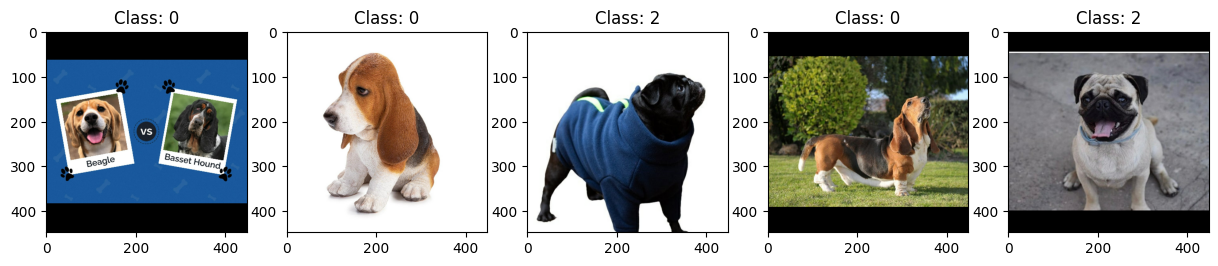

In [7]:
def apply_preproc(img, label):
    x = tf.image.resize_with_pad(img, 2*IMG_HEIGHT, 2*IMG_WIDTH)
    # Cast to integer
    x = tf.cast(x, tf.uint8)
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(shuffled_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()))
    ax[idx].set_title('Class: {}'.format(label_int.numpy()))

## Resizing by center cropping

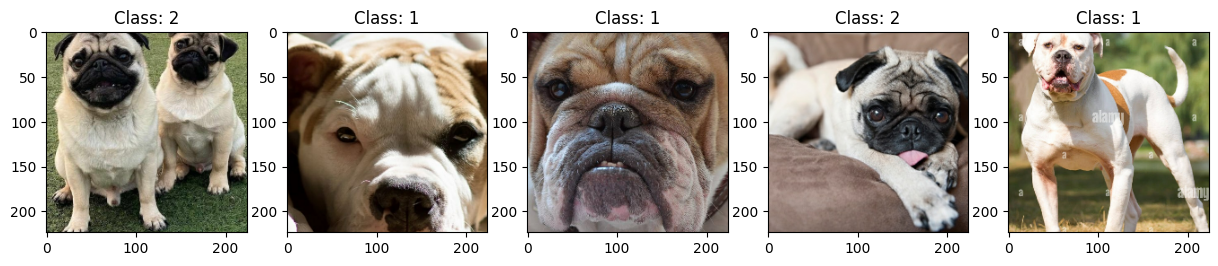

In [8]:
preproc_layers = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda img:
                           tf.image.resize_with_pad(
                               img, 2*IMG_HEIGHT, 2*IMG_WIDTH),
                           input_shape=(None, None, 3)),
    tf.keras.layers.experimental.preprocessing.CenterCrop(
        height=IMG_HEIGHT, width=IMG_WIDTH)
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    # Cast to integer
    x = tf.cast(x, tf.uint8)
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(shuffled_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()))
    ax[idx].set_title('Class: {}'.format(label_int.numpy()))

### Full pipeline
Batch the dataset will al images of the same size

In [38]:
NUM_CLASSES=3
# Function to map labels to one-hot encoded format
def map_labels(img, label):
    one_hot_label = tf.one_hot(label, depth=NUM_CLASSES)
    return img, one_hot_label

In [45]:
batch_size = 4
IMG_CHANNELS=3

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 4,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    train_dataset = shuffled_dataset.map(apply_preproc).map(map_labels).batch(batch_size)
    # Note: val dataset was not loaded
    eval_dataset = tf.data.TFRecordDataset(
        [val_tfrecord]).map(parse_tfrecord).shuffle(buffer_size).map(
        apply_preproc).map(map_labels).batch(batch_size)

    # Define model
    layers_ = [
        layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='input_layer'),
        layers.Flatten(name='flatten_layer'),
        layers.Dense(num_hidden,
                    kernel_regularizer=regularizer, 
                    activation=tf.keras.activations.relu,
                    name='dense_hidden_1'),
        layers.Dense(num_hidden,
                    kernel_regularizer=regularizer, 
                    activation=tf.keras.activations.relu,
                    name='dense_hidden_2'),
        layers.Dense(NUM_CLASSES,  
                    activation='softmax', 
                    name='breed_prob')
    ]
    # Create model
    model = models.Sequential(layers_, name='dog_breed_classification')
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
            loss=tf.keras.losses.CategoricalCrossentropy(
                from_logits=False),
            metrics=['accuracy'])
    # Show model layers
    
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "dog_breed_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 150528)            0         
                                                                 
 dense_hidden_1 (Dense)      (None, 16)                2408464   
                                                                 
 dense_hidden_2 (Dense)      (None, 16)                272       
                                                                 
 breed_prob (Dense)          (None, 3)                 51        
                                                                 
Total params: 2408787 (9.19 MB)
Trainable params: 2408787 (9.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
51/51 [==============================] - 6s 74ms/step - loss: 1998.1350 - accuracy: 0.3103 - val_loss: 3604.7080 - val_a

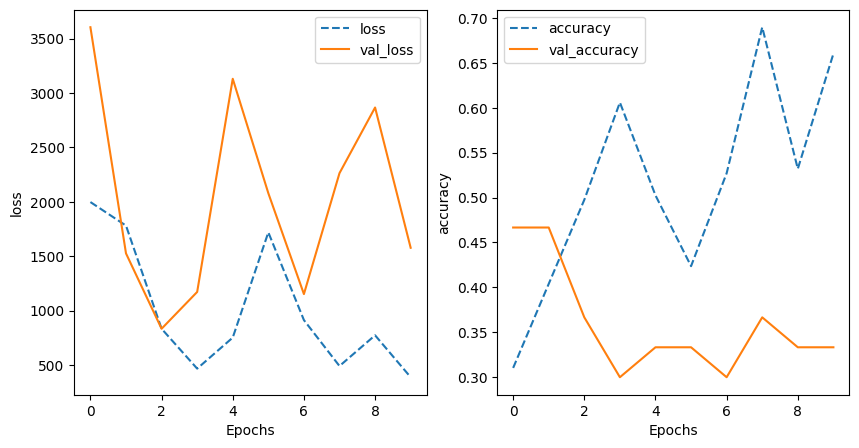

In [46]:
model = train_and_evaluate()